# 1.实验背景及目标

某电商公司非常注重自己的落地页设计，希望通过改进设计来提高转化率。以往该公司全年转化率平均在13%左右，现在希望设计的新页恒能够带来更高的转化率，希望新页面的转化率能有2%的提升，达到15%。在正式推出新页面之前，该公司希望通过AB测试在小范围的用户中进行测试，以确保新页面的效果能够达到预期目标。

# 2.提出假设

原假设：p=p0,即新页面与旧页面无明显差异
备择假设：p≠p0,即新页面与旧页面有明显差异

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# 3. 数据预览

In [2]:
# 导入数据
df = pd.read_csv('/kaggle/input/ab-data/ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


* user_id:用户ID
* timestamp:用户访问页面时间
* group:用户分组情况【treatment-新；control-旧】
* landing_page: 分到的页面，与group字段一一对应
* converted:是否成功转化

In [4]:
df['group'].value_counts()

group
treatment    147276
control      147202
Name: count, dtype: int64

# 4. 数据清洗

In [5]:
# 检查缺失值
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [6]:
# 检查重复值
df.duplicated().sum()

0

In [7]:
# 检查用户ID的重复情况
df['user_id'].duplicated().sum()

3894

In [8]:
# 查询出ID重复用户的数据
df[df['user_id'].duplicated()]['user_id']

2656      698120
2893      773192
7500      899953
8036      790934
10218     633793
           ...  
294308    905197
294309    787083
294328    641570
294331    689637
294355    744456
Name: user_id, Length: 3894, dtype: int64

In [9]:
# 查看其中某位id重复用户的情况【抽查】
df[df['user_id'] == 698120]

,user_id,timestamp,group,landing_page,converted
988,698120,2017-01-22 07:09:37.540970,control,new_page,0
2656,698120,2017-01-15 17:13:42.602796,control,old_page,0


In [10]:
# 存储下所有ID重复用户的ID
del_id = df[df['user_id'].duplicated()]['user_id'].values
del_id

array([698120, 773192, 899953, ..., 641570, 689637, 744456])

In [11]:
# 删除ID重复的用户
df_new = df[~df['user_id'].isin(del_id)]
df_new

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


* 下面处理时间字段

In [12]:
pd.to_datetime(df_new['timestamp'], format='%Y-%m-%d %H:%M:%S.%f')

0        2017-01-21 22:11:48.556739
1        2017-01-12 08:01:45.159739
2        2017-01-11 16:55:06.154213
3        2017-01-08 18:28:03.143765
4        2017-01-21 01:52:26.210827
                    ...            
294473   2017-01-03 22:28:38.630509
294474   2017-01-12 00:51:57.078372
294475   2017-01-22 11:45:03.439544
294476   2017-01-15 01:20:28.957438
294477   2017-01-16 12:40:24.467417
Name: timestamp, Length: 286690, dtype: datetime64[ns]

In [13]:
# 处理时间并处理
df_new['timestamp'] = pd.to_datetime(df_new['timestamp'], format='%Y-%m-%d %H:%M:%S.%f').dt.strftime('%Y-%m-%d')
df_new['timestamp']

<ipython-input-13-c8f2b889eb74>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['timestamp'] = pd.to_datetime(df_new['timestamp'], format='%Y-%m-%d %H:%M:%S.%f').dt.strftime('%Y-%m-%d')


0         2017-01-21
1         2017-01-12
2         2017-01-11
3         2017-01-08
4         2017-01-21
             ...    
294473    2017-01-03
294474    2017-01-12
294475    2017-01-22
294476    2017-01-15
294477    2017-01-16
Name: timestamp, Length: 286690, dtype: object

In [14]:
# 查看实验周期
len(df_new['timestamp'].unique())

23

In [15]:
# 检查处理完毕后的数据
df_new.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21,control,old_page,0
1,804228,2017-01-12,control,old_page,0
2,661590,2017-01-11,treatment,new_page,0
3,853541,2017-01-08,treatment,new_page,0
4,864975,2017-01-21,control,old_page,1


In [16]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 286690 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       286690 non-null  int64 
 1   timestamp     286690 non-null  object
 2   group         286690 non-null  object
 3   landing_page  286690 non-null  object
 4   converted     286690 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.1+ MB


* 检查确定group和landing_page的值一一对应

In [17]:
# 利用交叉表检查：确保contorl组的用户看到的是旧页面；treament组看到的是新页面
pd.crosstab(df_new['group'], df_new['landing_page'])

landing_page,new_page,old_page
group,,
control,0,143293
treatment,143397,0


# 5. 假设检验

In [18]:
# 每组随机抽取5000个样本
required_n = 5000
control_sample = df_new[df_new['group'] == 'control'].sample(n=required_n)
treatment_sample = df_new[df_new['group'] == 'treatment'].sample(n=required_n)
ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test

,user_id,timestamp,group,landing_page,converted
0,644036,2017-01-02,control,old_page,0
1,639507,2017-01-03,control,old_page,0
2,676723,2017-01-22,control,old_page,0
3,857987,2017-01-03,control,old_page,0
4,846620,2017-01-09,control,old_page,0
...,...,...,...,...,...
9995,885077,2017-01-23,treatment,new_page,0
9996,912811,2017-01-17,treatment,new_page,0
9997,764680,2017-01-14,treatment,new_page,0
9998,938454,2017-01-14,treatment,new_page,0


In [19]:
# 利用交叉表检查：确保contorl组的用户看到的是旧页面；treament组看到的是新页面
pd.crosstab(ab_test['group'], ab_test['landing_page'])

landing_page,new_page,old_page
group,,
control,0,5000
treatment,5000,0


* 计算转化率并可视化

In [20]:
# 转化率与方差
c_r = ab_test.groupby('group')['converted'].agg([np.mean, np.std])
c_r.columns = ['conversion_rate', 'std_deviation'] 
c_r

<ipython-input-20-05f834f41d40>:2: FutureWarning: The provided callable <function mean at 0x7c03547e0790> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  c_r = ab_test.groupby('group')['converted'].agg([np.mean, np.std])
<ipython-input-20-05f834f41d40>:2: FutureWarning: The provided callable <function std at 0x7c03547e08b0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  c_r = ab_test.groupby('group')['converted'].agg([np.mean, np.std])


,conversion_rate,std_deviation
group,,
control,0.117,0.321452
treatment,0.113,0.316624


<ipython-input-21-b3fb5a9882d5>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.barplot(x=ab_test['group'], y=df_new['converted'], ci=False)


Text(0, 0.5, 'conversion rate')

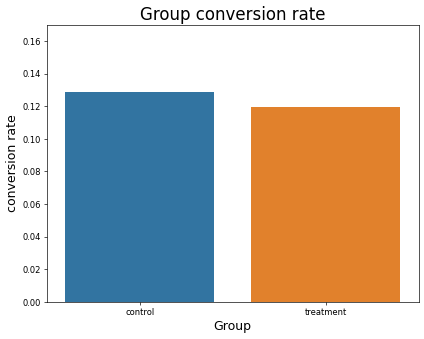

In [21]:
# 可视化
plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(8,6), dpi=60)

sns.barplot(x=ab_test['group'], y=df_new['converted'], ci=False)

plt.ylim(0, 0.17)
plt.title('Group conversion rate', fontsize=20)
plt.xlabel('Group', fontsize=15)
plt.ylabel('conversion rate', fontsize=15)

* 高出0.3%是否是显著
* 假设检验

In [22]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [23]:
# 提取购买结果
c_results = ab_test[ab_test['group'] == 'control']['converted']
t_results = ab_test[ab_test['group'] == 'treatment']['converted']

# 计算数量
n_c = c_results.count()
n_t = t_results.count()
successes = [c_results.sum(), t_results.sum()]
nobs = [n_c, n_t]
nobs

[5000, 5000]

In [24]:
# Z检验
# 计算得到Z值和p值
z_stat, pval = proportions_ztest(successes, nobs = nobs)
# 置信区间【95%】
(lower_c, lower_t), (upper_c, upper_t) = proportion_confint(successes, nobs = nobs, alpha=0.05)
print(f'z_stat:{z_stat:.2f}')
print(f'p:{pval:.2f}')
print(f'95% for control:[{lower_c:.3f}, {upper_c:.3f}]')
print(f'95% for treatment:[{lower_t:.3f}, {upper_t:.3f}]')

z_stat:0.63
p:0.53
95% for control:[0.108, 0.126]
95% for treatment:[0.104, 0.122]


* p值>>显著性水平，从而不能拒绝原假设；
* treatment组【实验组】的置信区间不包含我们预期的15%，同样也说明新方案无法达到预期。